In [6]:
import numpy as np
from scipy.optimize import minimize
from functools import partial
from matplotlib import pyplot as plt
from tabulate import tabulate

In [7]:
def partial_func(func, mode, partial_x, given_x={}):
    x = []
    total_x = len(partial_x) + len(given_x)

    pid = 0
    for i in range(total_x):
        if i in given_x:
            x.append(given_x[i])
        else:
            x.append(partial_x[pid])
            pid += 1            
    
    value, grad = func(x)
    
    if mode == 'backward':
        partial_grad = []
        for i in range(total_x):
            if i not in given_x:
                partial_grad.append(grad[i])
        return np.array(partial_grad)
    elif mode == 'forward':
        return value

In [8]:
def f1(vec):
    x, y = vec
    value = x ** 2 - 2 * (y - 4) * x + 2 * y ** 2
    grad = (2 * x - 2 * (y - 4), - 2 * x + 4 * y)
    return value, grad

def f2(vec):
    x, y = vec
    value = 3 * x ** 2 - 2 * (y + 4) * x + 1 * y ** 2
    grad = (6 * x - 2 * (y + 4), - 2 * x + 2 * y)
    return value, grad

def fall(vec):
    x1, x2, y = vec
    v1, g1 = f1([x1, y])
    v2, g2 = f2([x2, y])
    v = v1 + v2
    g = (g1[0], g2[0], g1[1] + g2[1])
    return v, g

def f1_dual(vec):
    x, y, lmb = vec
    v, g = f1([x, y])
    v = v + lmb * y
    g = (g[0], g[1] + lmb, y)
    return v, g

def f2_dual(vec):
    x, y, lmb = vec
    v, g = f2([x, y])
    v = v - lmb * y
    g = (g[0], g[1] - lmb, -y)
    return v, g


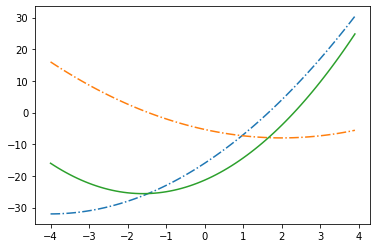

In [9]:
ys = np.arange(-4, 4, 0.1)
for f in [f1, f2, fall]:
    fs = []
    for y in ys:
        if f in [f1, f2]:
            kwargs = dict(
                x0=np.array([0.0]),  
                args=({1: y}, ), 
                bounds=((-10.0, 10.0), ),
            )
        else:
            kwargs = dict(
                x0=np.array([0.0, 0.0]),
                args=({2: y}, ),   
                bounds=((-10.0, 10.0), (-10.0, 10.0))             
            )
        res = minimize(
            fun=partial(partial_func, f, 'forward'), 
            jac=partial(partial_func, f, 'backward'), 
            **kwargs
        )
        fs.append(res.fun)
    if f in [f1, f2]:
        plt.plot(ys, fs, '-.')
    else:
        plt.plot(ys, fs)

We write the dual function and set its derivative to $0$:

$$
\begin{aligned}
f_1^{dual} = & f_1(x_1, y_1) + \lambda y_1\\
\frac{\partial f_1^{dual}}{\partial y_1} = & 0\\
\end{aligned}
$$

Then we get $y_1^*$, the point where the derivative cross the axis. 

A key point: since $y_1^*$ is the minimum, **the derivative function cross the axis from bottom-left to top-right (the slope is positive)**.

$$
y_1^* = \argmin_{y_1} f_1^{dual}
$$

If we perform an update on $\lambda$,
$$
\lambda := \lambda + \alpha (y_1^* - y_2^*),\mathrm{~}\alpha \gt 0
$$

We write the new dual function and set the new derivative to $0$:
$$
f_1^{new~dual} = f_1^{dual} + \alpha (y_1^* - y_2^*) y_1 \\
\frac{\partial f_1^{dual}}{\partial y_1} + \alpha (y_1^* - y_2^*) = 0 \\
\frac{\partial f_1^{dual}}{\partial y_1} = - \alpha (y_1^* - y_2^*)  \\
$$

```
           ^              
           |           / df/dy
           |          /
           |         /
--------------------y1*------> y
           |    :  /
           |    : /
-(y1*-y2*) |...../
           |    /
           |   /
```
if $y_1^* \gt y_2^*$, then the new $y_1^*$ will be smaller than $y_1^*$.

In [18]:
y1, y2 = None, None
lmb = 10.0
table = []

for i in range(20):
    res1_dual, res2_dual = None, None
    for y, f in ((y1, f1_dual), (y2, f2_dual)):
        kwargs = dict(
            x0=np.array([0.0, 0.0]),  
            args=({2: lmb}, ), 
            bounds=((-10.0, 10.0), (-4.0, 4.0),),
        )
        res = minimize(
            fun=partial(partial_func, f, 'forward'), 
            jac=partial(partial_func, f, 'backward'), 
            **kwargs
        )
        if f == f1_dual:
            res1_dual = res.fun
            x1, y1 = res.x[0], res.x[1]
        elif f == f2_dual:
            res2_dual = res.fun
            x2, y2 = res.x[0], res.x[1]
    lmb += 0.3 * (y1 - y2)
    dual = res1_dual + res2_dual
    table.append((lmb, y1, y2, res1_dual, res2_dual, dual))
print(tabulate(table, headers=['lmb', 'y1', 'y2', 'dual1', 'dual2', 'dual']))

     lmb        y1          y2     dual1      dual2       dual
--------  --------  ----------  --------  ---------  ---------
 7.6      -4         4          -72       -45.3333   -117.333
 5.2      -4         4          -62.4     -35.7333    -98.1333
 2.8      -4         4          -52.8     -26.1333    -78.9333
 0.4      -4         4          -43.2     -16.5333    -59.7333
-1.49     -4         2.3        -33.6      -8.86      -42.46
-2.73125  -3.255     0.8825     -26.595    -5.85254   -32.4476
-3.50703  -2.63438  -0.0484375  -22.9399   -5.3349    -28.2748
-3.99189  -2.24648  -0.630273   -21.0467   -5.59816   -26.6449
-4.29493  -2.00405  -0.993921   -20.0162   -5.99192   -26.0081
-4.48433  -1.85253  -1.2212     -19.4319   -6.32755   -25.7594
-4.60271  -1.75783  -1.36325    -19.09     -6.5723    -25.6623
-4.67669  -1.69865  -1.45203    -18.8854   -6.73893   -25.6243
-4.72293  -1.66165  -1.50752    -18.7611   -6.84841   -25.6095
-4.75183  -1.63853  -1.5422     -18.6848   -6.91892   -25.